In [1]:
import os, re, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dateutil import parser
from joblib import dump, load

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Display / plotting defaults
pd.set_option('display.max_columns', 200)
warnings.filterwarnings("ignore")

print("pandas:", pd.__version__)
print("numpy:", np.__version__)

pandas: 2.2.3
numpy: 2.2.3


In [5]:
data_dir = r"C:\Pattern\model\AI-Statement-IntelliScan\MockStatementAIPT\Labled\Normal"


data_dir = os.path.expanduser(data_dir)
print("Data dir:", data_dir)

# Discover Excel files
excel_files = [
    os.path.join(data_dir, f)
    for f in os.listdir(data_dir)
    if f.lower().endswith(('.xlsx', '.xls'))
]


print("พบไฟล์ Excel ทั้งหมด:", excel_files)


Data dir: C:\Pattern\model\AI-Statement-IntelliScan\MockStatementAIPT\Labled\Normal
พบไฟล์ Excel ทั้งหมด: ['C:\\Pattern\\model\\AI-Statement-IntelliScan\\MockStatementAIPT\\Labled\\Normal\\statement-Anne-Aug2023-Sep2023_labeled-6-5.xlsx', 'C:\\Pattern\\model\\AI-Statement-IntelliScan\\MockStatementAIPT\\Labled\\Normal\\statement-Anne-Dec2023-May2024_labeled-2-1.xlsx', 'C:\\Pattern\\model\\AI-Statement-IntelliScan\\MockStatementAIPT\\Labled\\Normal\\statement-Anne-Dec2024-Feb2025_labeled.xlsx', 'C:\\Pattern\\model\\AI-Statement-IntelliScan\\MockStatementAIPT\\Labled\\Normal\\statement-Anne-Dec2024-May2025_labeled-4-3.xlsx', 'C:\\Pattern\\model\\AI-Statement-IntelliScan\\MockStatementAIPT\\Labled\\Normal\\statement-Anne-Feb2024-Jul2024_labeled-6-5.xlsx', 'C:\\Pattern\\model\\AI-Statement-IntelliScan\\MockStatementAIPT\\Labled\\Normal\\statement-Anne-Feb2024-Mar2024_labeled.xlsx', 'C:\\Pattern\\model\\AI-Statement-IntelliScan\\MockStatementAIPT\\Labled\\Normal\\statement-Anne-Feb2025-Apr2

In [6]:
def load_first_sheet(path: str) -> pd.DataFrame:
    xls = pd.ExcelFile(path)
    sheet_name = xls.sheet_names[0]
    df = pd.read_excel(path, sheet_name=sheet_name)
    df['__source_file'] = os.path.basename(path)
    df['__sheet'] = sheet_name
    return df

frames = []
for f in excel_files:
    p = os.path.join(data_dir, f)
    try:
        frames.append(load_first_sheet(p))
        print("โหลดสำเร็จ:", p)
    except Exception as e:
        print("ข้ามไฟล์ (โหลดไม่สำเร็จ):", p, "เพราะ", e)

if not frames:
    raise RuntimeError("ไม่มีไฟล์ใดโหลดได้ ตรวจสอบโครงสร้างชีท/ไฟล์อีกครั้ง")

df_raw = pd.concat(frames, ignore_index=True)
print("รวมได้จำนวนแถว:", len(df_raw))
display(df_raw.head(10))

โหลดสำเร็จ: C:\Pattern\model\AI-Statement-IntelliScan\MockStatementAIPT\Labled\Normal\statement-Anne-Aug2023-Sep2023_labeled-6-5.xlsx
โหลดสำเร็จ: C:\Pattern\model\AI-Statement-IntelliScan\MockStatementAIPT\Labled\Normal\statement-Anne-Dec2023-May2024_labeled-2-1.xlsx
โหลดสำเร็จ: C:\Pattern\model\AI-Statement-IntelliScan\MockStatementAIPT\Labled\Normal\statement-Anne-Dec2024-Feb2025_labeled.xlsx
โหลดสำเร็จ: C:\Pattern\model\AI-Statement-IntelliScan\MockStatementAIPT\Labled\Normal\statement-Anne-Dec2024-May2025_labeled-4-3.xlsx
โหลดสำเร็จ: C:\Pattern\model\AI-Statement-IntelliScan\MockStatementAIPT\Labled\Normal\statement-Anne-Feb2024-Jul2024_labeled-6-5.xlsx
โหลดสำเร็จ: C:\Pattern\model\AI-Statement-IntelliScan\MockStatementAIPT\Labled\Normal\statement-Anne-Feb2024-Mar2024_labeled.xlsx
โหลดสำเร็จ: C:\Pattern\model\AI-Statement-IntelliScan\MockStatementAIPT\Labled\Normal\statement-Anne-Feb2025-Apr2025_labeled.xlsx
โหลดสำเร็จ: C:\Pattern\model\AI-Statement-IntelliScan\MockStatementAIPT\La

,tx_datetime,code_channel_raw,debit_amount,credit_amount,balance_amount,description_text,fraud_label,__source_file,__sheet,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,fraud_label.1,Unnamed: 27,Unnamed: 28,Unnamed: 29,split
0,2023-08-01 03:42:00,X1/ATS,0.00,18299.28,59265.05,DESC: ร้านอาหาร บ้านสวน | NOTE: -,0,statement-Anne-Aug2023-Sep2023_labeled-6-5.xlsx,statement-Anne-Aug2023-Sep2023_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-08-01 16:56:00,C1/ATM,54607.37,0.00,4657.68,DESC: ร้านอาหาร บ้านสวน | NOTE: -,1,statement-Anne-Aug2023-Sep2023_labeled-6-5.xlsx,statement-Anne-Aug2023-Sep2023_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-08-02 01:31:00,C2/ATM,0.00,1105.17,5762.85,DESC: ค่าน้ำการประปานครหลวง | NOTE: -,0,statement-Anne-Aug2023-Sep2023_labeled-6-5.xlsx,statement-Anne-Aug2023-Sep2023_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-08-02 17:22:00,C1/ATM,5455.71,0.00,307.14,DESC: SIPS TRUE MONEY CO.LTD. | NOTE: -,1,statement-Anne-Aug2023-Sep2023_labeled-6-5.xlsx,statement-Anne-Aug2023-Sep2023_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-08-04 14:13:00,X1/ATS,0.00,1517.64,1824.78,DESC: SIPS TRUE MONEY CO.LTD. | NOTE: -,1,statement-Anne-Aug2023-Sep2023_labeled-6-5.xlsx,statement-Anne-Aug2023-Sep2023_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2023-08-05 08:25:00,C1/ATM,981.41,0.00,843.37,DESC: เติมเงินมือถือ AIS | NOTE: -,0,statement-Anne-Aug2023-Sep2023_labeled-6-5.xlsx,statement-Anne-Aug2023-Sep2023_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2023-08-06 16:19:00,C2/ATM,0.00,1692.45,2535.82,DESC: ค่ากาแฟ CafeKU | NOTE: -,1,statement-Anne-Aug2023-Sep2023_labeled-6-5.xlsx,statement-Anne-Aug2023-Sep2023_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2023-08-06 20:23:00,X1/ENET,0.00,906.43,3442.25,DESC: ค่ากาแฟ CafeKU | NOTE: -,0,statement-Anne-Aug2023-Sep2023_labeled-6-5.xlsx,statement-Anne-Aug2023-Sep2023_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2023-08-07 19:47:00,C1/ATM,0.00,2098.05,5540.30,DESC: โอนเข้า KTB x2808 และวัฒกุล ประกาสิน | N...,0,statement-Anne-Aug2023-Sep2023_labeled-6-5.xlsx,statement-Anne-Aug2023-Sep2023_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2023-08-09 00:12:00,X2/ATM,2330.95,0.00,878.40,DESC: SIPS TRUE MONEY CO.LTD. | NOTE: -,1,statement-Anne-Aug2023-Sep2023_labeled-6-5.xlsx,statement-Anne-Aug2023-Sep2023_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
rename_map = {
    "tx_datetime": "DateTime",
    "code_channel_raw": "CodeChannelRaw",
    "debit_amount": "Debit",
    "credit_amount": "Credit",
    "balance_amount": "Balance",
    "description_text": "DescRaw",
}
df = df_raw.rename(columns=rename_map).copy()

# Ensure required columns exist (create if missing)
for col in ["DateTime","CodeChannelRaw","Debit","Credit","Balance","DescRaw"]:
    if col not in df.columns:
        # create empty if not found
        if col == "DateTime":
            df[col] = pd.NaT
        elif col in ["Debit","Credit","Balance"]:
            df[col] = 0.0
        else:
            df[col] = ""

def parse_datetime_naive(val):
    try:
        dt = parser.parse(str(val))
        if dt.tzinfo is not None:
            dt = dt.replace(tzinfo=None)
        return dt
    except Exception:
        return pd.NaT

df["DateTime"] = df["DateTime"].apply(parse_datetime_naive)
df = df.dropna(subset=["DateTime"])

for col in ["Debit", "Credit", "Balance"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0.0)

# Split "DescRaw" into "Description" & "Note" if pattern "DESC: ... | NOTE: ..."
desc = df.get("DescRaw", "").astype(str).fillna("")
desc = desc.str.replace("DESC:", "", regex=False)
parts = desc.str.split("| NOTE:", n=1, expand=True)
df["Description"] = parts[0].str.strip()
df["Note"] = parts[1].str.strip() if isinstance(parts, pd.DataFrame) and parts.shape[1] == 2 else ""

df = df.sort_values("DateTime").reset_index(drop=True)
display(df[["DateTime","Debit","Credit","Balance","Description","Note"]].head(10))

,DateTime,Debit,Credit,Balance,Description,Note
0,2023-01-01 07:58:00,1225.45,0.00,198546.51,,ร้านอาหาร บ้านสวน | NOTE: -
1,2023-01-01 08:21:00,17344.00,0.00,116567.00,,Transfer Withdrawal Nobook | CH:ATS | NOTE: -
2,2023-01-01 08:49:00,0.00,1229.63,199776.14,,ค่าน้ำการประปานครหลวง | NOTE: -
3,2023-01-01 10:55:00,0.00,79567.00,92134.00,,Cash Deposit Nobook | CH:ATM | NOTE: -
4,2023-01-01 13:44:00,0.00,6489.00,41748.00,,Transfer Deposit Nobook | CH:ATS | NOTE: -
5,2023-01-01 16:24:00,1628.06,0.00,198148.08,,โอนเข้า KTB x2808 และวัฒกุล ประกาสิน | NOTE: -
6,2023-01-01 23:02:00,0.00,3122.09,201270.17,,เติมเงินมือถือ AIS | NOTE: -
7,2023-01-02 05:47:00,0.00,40466.00,165676.00,,Transfer Deposit Nobook | CH:ENET | NOTE: -
8,2023-01-02 07:53:00,620.11,0.00,200650.06,,ชำระเงิน KU KPS - STORE 11 | NOTE: -
9,2023-01-02 09:44:00,1858.96,0.00,198791.10,,SIPS TRUE MONEY CO.LTD. | NOTE: -


In [8]:
def map_channel(raw, description, debit, credit):
    raw = str(raw).upper()
    d = str(description).lower()

    # From description (higher priority)
    if "cash withdrawal" in d:
        return "ATM-WD"
    if "cash deposit" in d:
        return "CASH-DEP"
    if "transfer deposit" in d:
        return "MOBILE-TRF"   # in
    if "transfer withdrawal" in d:
        return "WEB-TRF"      # out
    if "qr" in d and "pay" in d:
        return "QR-PAY"
    if "pos" in d:
        return "POS"

    # From raw code
    if "ATM" in raw:
        return "ATM-WD"
    if "X1/ENET" in raw or "X2/ENET" in raw:
        return "WEB-TRF"
    if "C1/ENET" in raw or "C2/ENET" in raw:
        # Direction fallback
        if pd.notna(debit) and debit > 0:
            return "ATM-WD"
        if pd.notna(credit) and credit > 0:
            return "CASH-DEP"
        return "CASH/ATM"

    # fallback
    return raw if raw else "UNKNOWN"

df['CodeChannel'] = df.apply(
    lambda r: map_channel(r.get('CodeChannelRaw', ""), r.get('Description', ""), r.get('Debit', 0.0), r.get('Credit', 0.0)),
    axis=1
)
display(df[['DateTime','CodeChannel','Debit','Credit','Balance','Description']].head(12))

,DateTime,CodeChannel,Debit,Credit,Balance,Description
0,2023-01-01 07:58:00,X2/ATS,1225.45,0.00,198546.51,
1,2023-01-01 08:21:00,X2/ATS,17344.00,0.00,116567.00,
2,2023-01-01 08:49:00,X1/ATS,0.00,1229.63,199776.14,
3,2023-01-01 10:55:00,ATM-WD,0.00,79567.00,92134.00,
4,2023-01-01 13:44:00,X1/ATS,0.00,6489.00,41748.00,
5,2023-01-01 16:24:00,ATM-WD,1628.06,0.00,198148.08,
6,2023-01-01 23:02:00,X2/ATS,0.00,3122.09,201270.17,
7,2023-01-02 05:47:00,WEB-TRF,0.00,40466.00,165676.00,
8,2023-01-02 07:53:00,ATM-WD,620.11,0.00,200650.06,
9,2023-01-02 09:44:00,X1/ATS,1858.96,0.00,198791.10,


In [10]:
RISKY_WORDS = [
    "refund??","chargeback","short.ly","verify","urgent","crypto","giftcard",
    "verify now","urgent transfer","out of hours","unknown merchant","test"
]

def build_features(df: pd.DataFrame):
    x = df.copy()

    # Disambiguate CASH/ATM bucket
    x.loc[(x['CodeChannel']=="CASH/ATM") & (x['Debit']>0),  'CodeChannel'] = "ATM-WD"
    x.loc[(x['CodeChannel']=="CASH/ATM") & (x['Credit']>0), 'CodeChannel'] = "CASH-DEP"

    x['hour'] = x['DateTime'].dt.hour
    x['dow'] = x['DateTime'].dt.dayofweek
    x['is_night'] = ((x['hour'] >= 1) & (x['hour'] <= 4)).astype(int)
    x['is_weekend'] = (x['dow'] >= 5).astype(int)

    x['amount'] = (x['Credit'].fillna(0) - x['Debit'].fillna(0)).astype(float)
    x['abs_amount'] = x['amount'].abs()

    dummies = pd.get_dummies(x['CodeChannel'].fillna("UNKNOWN"), prefix='ch')
    x = pd.concat([x, dummies], axis=1)

    low_desc = x['Description'].astype(str).str.lower().fillna("")
    x['desc_risky'] = 0
    for kw in [k.lower() for k in RISKY_WORDS]:
        x['desc_risky'] |= low_desc.str.contains(kw).astype(int)

    tmp = x.set_index('DateTime').sort_index()
    x['roll_mean14'] = tmp['abs_amount'].rolling('14D', min_periods=7).mean().values
    x['roll_std14']  = tmp['abs_amount'].rolling('14D', min_periods=7).std().fillna(0).values

    for col in ['roll_mean14','roll_std14']:
        x[col] = x[col].fillna(x[col].median())

    feat_cols = ['abs_amount','is_night','is_weekend','hour','dow','desc_risky','roll_mean14','roll_std14'] + \
                [c for c in x.columns if c.startswith('ch_')]
    return x, feat_cols

X_all, FEATURE_COLS = build_features(df)
display(X_all[FEATURE_COLS].head())
print("Total features:", len(FEATURE_COLS))

,abs_amount,is_night,is_weekend,hour,dow,desc_risky,roll_mean14,roll_std14,ch_ATM-WD,ch_C1/ATS,ch_C2/ATS,ch_CASH-DEP,ch_WEB-TRF,ch_X1/ATS,ch_X2/ATS
0,1225.45,0,1,7,6,0,26447.880242,0.0,False,False,False,False,False,False,True
1,17344.00,0,1,8,6,0,26447.880242,0.0,False,False,False,False,False,False,True
2,1229.63,0,1,8,6,0,26447.880242,0.0,False,False,False,False,False,True,False
3,79567.00,0,1,10,6,0,26447.880242,0.0,True,False,False,False,False,False,False
4,6489.00,0,1,13,6,0,26447.880242,0.0,False,False,False,False,False,True,False


Total features: 15


In [12]:
def weak_label_rules(x: pd.DataFrame, global_channel_stats: dict | None = None):
    y = np.zeros(len(x), dtype=int)

    # 1) z-like score on absolute amount
    z = (x['abs_amount'] - (x['roll_mean14'] + 1e-6)) / (x['roll_std14'] + 1.0)
    y |= (z > 2.5).astype(int)

    # 2) night-time
    y |= (x['is_night'] == 1).astype(int)

    # 3) rare channels
    channel_cols = [c for c in x.columns if c.startswith('ch_')]
    if global_channel_stats is None:
        freq = X_all[channel_cols].mean().to_dict()  # global freq from full set
    else:
        freq = global_channel_stats

    rare_hit = np.zeros(len(x), dtype=int)
    for c in channel_cols:
        if freq.get(c, 0.0) < 0.05:
            rare_hit |= x[c].astype(int).values
    y |= rare_hit

    # 4) risky words
    y |= x['desc_risky'].astype(int)

    return y

# Compute weak labels
y_rules = weak_label_rules(X_all)
df['WeakLabel'] = y_rules
display(df[['DateTime','CodeChannel','Debit','Credit','Balance','Description','WeakLabel']].head(12))
print("Weak positives:", df['WeakLabel'].sum(), "/", len(df))


,DateTime,CodeChannel,Debit,Credit,Balance,Description,WeakLabel
0,2023-01-01 07:58:00,X2/ATS,1225.45,0.00,198546.51,,0
1,2023-01-01 08:21:00,X2/ATS,17344.00,0.00,116567.00,,0
2,2023-01-01 08:49:00,X1/ATS,0.00,1229.63,199776.14,,0
3,2023-01-01 10:55:00,ATM-WD,0.00,79567.00,92134.00,,1
4,2023-01-01 13:44:00,X1/ATS,0.00,6489.00,41748.00,,0
5,2023-01-01 16:24:00,ATM-WD,1628.06,0.00,198148.08,,0
6,2023-01-01 23:02:00,X2/ATS,0.00,3122.09,201270.17,,0
7,2023-01-02 05:47:00,WEB-TRF,0.00,40466.00,165676.00,,0
8,2023-01-02 07:53:00,ATM-WD,620.11,0.00,200650.06,,0
9,2023-01-02 09:44:00,X1/ATS,1858.96,0.00,198791.10,,0


Weak positives: 1878 / 10273


In [13]:
X = X_all[FEATURE_COLS]
y = df['WeakLabel'].values

# แบ่ง Train 80% และชั่วคราว 20%
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# จาก 20% แบ่งครึ่งเป็น Val 10% และ Test 10%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# ===== 2) Scale บางฟีเจอร์ (ใช้ stat จาก train → transform val/test) =====
scale_cols = ['abs_amount','hour','dow','roll_mean14','roll_std14']
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_val_scaled[scale_cols]   = scaler.transform(X_val[scale_cols])
X_test_scaled[scale_cols]  = scaler.transform(X_test[scale_cols])

# ===== 3) Logistic Regression =====
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
pred_lr_val  = lr.predict(X_val_scaled)
pred_lr_test = lr.predict(X_test_scaled)

print("== Logistic Regression (Val) ==")
print(classification_report(y_val, pred_lr_val, digits=3))
print("== Logistic Regression (Test) ==")
print(classification_report(y_test, pred_lr_test, digits=3))

# ===== 4) Random Forest =====
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf_val  = rf.predict(X_val)
pred_rf_test = rf.predict(X_test)

print("== Random Forest (Val) ==")
print(classification_report(y_val, pred_rf_val, digits=3))
print("== Random Forest (Test) ==")
print(classification_report(y_test, pred_rf_test, digits=3))
print("Confusion Matrix (RF, Test):\n", confusion_matrix(y_test, pred_rf_test))

# ===== 5) IsolationForest (unsupervised anomalies) =====
# - ฝึกบน Train
# - ใช้ Val เพื่อหาค่า threshold (เช่น top 8% anomalous)
# - ประเมินบน Test
ana_cols = ['abs_amount','hour','dow','is_night','is_weekend','roll_mean14','roll_std14']

iso = IsolationForest(random_state=42, n_estimators=200, contamination=0.08)
iso.fit(X_train[ana_cols])

# คำนวณ "anom_score" = -decision_function (ค่ายิ่งสูง = ยิ่งแปลก)
anom_score_val  = -iso.decision_function(X_val[ana_cols])
anom_score_test = -iso.decision_function(X_test[ana_cols])

# เลือก threshold จากชุด Val (เช่น 92nd percentile ≈ top 8%)
thr = np.quantile(anom_score_val, 0.92)
pred_anom_val  = (anom_score_val  >= thr).astype(int)
pred_anom_test = (anom_score_test >= thr).astype(int)

print("\n== IsolationForest (Val) vs WeakLabel ==")
print(classification_report(y_val, pred_anom_val, digits=3))
print("== IsolationForest (Test) vs WeakLabel ==")
print(classification_report(y_test, pred_anom_test, digits=3))

# (ถ้าต้องการเก็บผล/คะแนนไว้ใช้ต่อ)
pred_lr  = pred_lr_test
pred_rf  = pred_rf_test
pred_anom = pred_anom_test
anom_score = anom_score_test

Train: 8218 | Val: 1027 | Test: 1028
== Logistic Regression (Val) ==
              precision    recall  f1-score   support

           0      0.996     1.000     0.998       839
           1      1.000     0.984     0.992       188

    accuracy                          0.997      1027
   macro avg      0.998     0.992     0.995      1027
weighted avg      0.997     0.997     0.997      1027

== Logistic Regression (Test) ==
              precision    recall  f1-score   support

           0      0.995     1.000     0.998       840
           1      1.000     0.979     0.989       188

    accuracy                          0.996      1028
   macro avg      0.998     0.989     0.993      1028
weighted avg      0.996     0.996     0.996      1028

== Random Forest (Val) ==
              precision    recall  f1-score   support

           0      0.998     0.999     0.998       839
           1      0.995     0.989     0.992       188

    accuracy                          0.997      1027


In [14]:
# Create test_mask to select test set rows from df
test_mask = df.index.isin(X_test.index)

res = df.loc[test_mask, ['DateTime','CodeChannel','Debit','Credit','Balance','Description','WeakLabel']].copy()
res = res.assign(Pred_RF=pred_rf, Pred_LR=pred_lr, Pred_ANOM=pred_anom, AnomScore=anom_score)

top = res.sort_values('AnomScore', ascending=False).head(30)
display(top)

# Save outputs
out_dir = Path("./outputs_intelliscan")
out_dir.mkdir(parents=True, exist_ok=True)

csv_path = out_dir / "flagged_transactions_all.csv"
rf_path  = out_dir / "rf_model_all.joblib"
scaler_path = out_dir / "scaler_all.joblib"

res.to_csv(csv_path, index=False, encoding="utf-8-sig")
dump(rf, rf_path); dump(scaler, scaler_path)

print("Saved:")
print(" -", csv_path.resolve())
print(" -", rf_path.resolve())
print(" -", scaler_path.resolve())


,DateTime,CodeChannel,Debit,Credit,Balance,Description,WeakLabel,Pred_RF,Pred_LR,Pred_ANOM,AnomScore
2256,2023-08-25 08:23:00,WEB-TRF,0.00,427.15,1664.29,,0,1,1,1,0.116793
2252,2023-08-24 22:27:00,X1/ATS,0.00,751.88,48256.57,,0,0,0,1,0.090810
423,2023-02-23 16:36:00,X2/ATS,5219.00,0.00,138482.00,,0,0,0,1,0.078492
6311,2024-09-11 15:17:00,X1/ATS,0.00,11192.00,113491.00,,0,1,1,1,0.069190
4747,2024-05-13 18:06:00,ATM-WD,10328.00,0.00,14612.00,,0,0,0,1,0.068911
10126,2025-08-12 21:00:00,WEB-TRF,0.00,686.38,11209.57,,0,1,1,1,0.067882
6511,2024-10-05 00:05:00,WEB-TRF,0.00,12255.00,181313.00,,0,1,1,1,0.066032
177,2023-01-29 12:50:00,ATM-WD,1059.89,0.00,83812.07,,0,1,1,1,0.065416
8469,2025-03-17 20:43:00,WEB-TRF,0.00,1066.21,5664.93,,0,0,0,1,0.065197
2853,2023-10-14 07:39:00,X2/ATS,14041.00,0.00,11927.00,,0,1,1,1,0.058080


Saved:
 - C:\Pattern\model\AI-Statement-IntelliScan\src\outputs_intelliscan\flagged_transactions_all.csv
 - C:\Pattern\model\AI-Statement-IntelliScan\src\outputs_intelliscan\rf_model_all.joblib
 - C:\Pattern\model\AI-Statement-IntelliScan\src\outputs_intelliscan\scaler_all.joblib


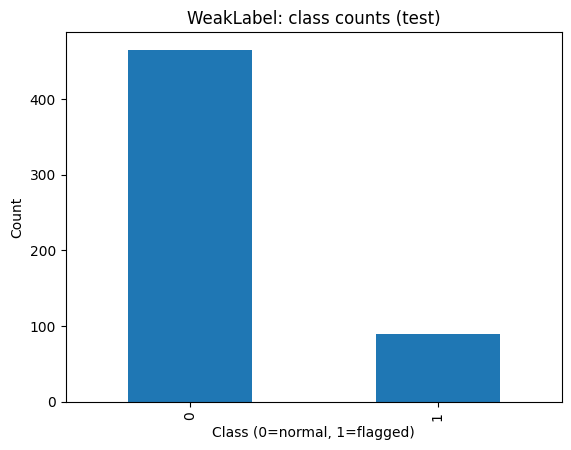

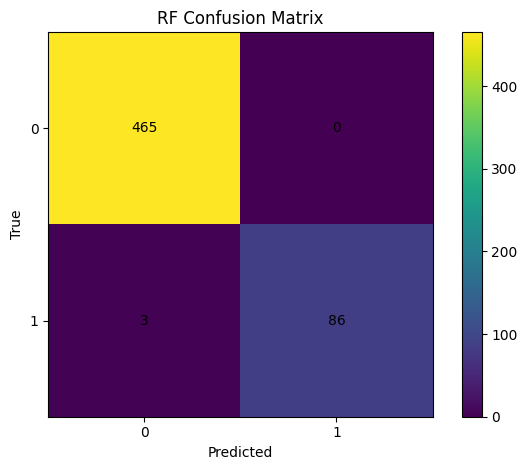

In [10]:
plt.figure()
counts = pd.Series(y_test).value_counts().sort_index()
counts.plot(kind="bar")
plt.title("WeakLabel: class counts (test)")
plt.xlabel("Class (0=normal, 1=flagged)")
plt.ylabel("Count")
plt.show()

# 10.2 Confusion matrix for RF
cm = confusion_matrix(y_test, pred_rf)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("RF Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0','1'])
plt.yticks(tick_marks, ['0','1'])
plt.xlabel('Predicted')
plt.ylabel('True')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()
